# 1. Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/spr_4711/code


In [2]:
from mobilkit.umni import *
from project import *

In [3]:
from IPython.display import display, HTML

# 2. SafeGraph

## 2.1. POI categories
Each SafeGraph POI category was manually classified by trip purpose and essentiality.

In [4]:
cats = pd.read_excel('../data/pois/sg_categories.xlsx', header=0, usecols='A:D').disp()

90 rows x 4 cols; Memory: 0.0 MiB


,top_category,count,purpose,category
,<object>,<int64>,<object>,<object>
0,Restaurants and Other Eating Places,12457,Social/Recreational,Food/Drink


In [5]:
c = cats.rename(columns=dict(top_category='sg_cat', count='n_pois'))
c.purpose = pd.Categorical(c.purpose.str.title(), [
    'Shopping', 'Social/Recreational', 'Services'])
c.category = c.category.str.title().astype(CAT)
c = (c.groupby(['purpose', 'category'])
     .agg({'n_pois': sum, 'sg_cat': list}).dropna()
     .rename_axis(('Purpose', 'Category')))
c.n_pois = [f'{x:,}' for x in c.n_pois]
c.sg_cat = c.sg_cat.apply(lambda x: '; '.join(sorted(x)))
c = c.rename(columns=dict(n_pois='No. of places', sg_cat='SafeGraph categories'))
U.disp_table(c, [dict(selector='td, th', props=[
    ('border', '1px solid grey !important'), ('text-align', 'left')]),
                 dict(selector='td:last-child', props=[
    ('font-size', '12px'), ('width', '500px')])])

## 2.2. Process POIs

In [6]:
def get_sg_pois(categories, region='IN', overwrite=False,
                inpath=SAFEGRAPH / 'pois/us/2020-11-06.parquet',
                outpath=Path('../data/pois/sg_pois.parquet')):
    if outpath.exists() and not overwrite:
        return gpd.read_parquet(outpath).set_crs(CRS_DEG)
    df = pd.read_parquet(inpath)
    df = df[df.region == region]
    df = mk.geo.pdf2gdf(df, 'lon', 'lat', CRS_DEG)
    df = df.merge(categories, on='top_category').astype({'essential': bool})
    df.category = df.category.str.title()
    df.nhts_purpose = df.nhts_purpose.str.title()
    df = df[['placekey', 'category', 'nhts_purpose',
             'essential', 'area_sqft', 'geometry']]
    df.to_parquet(U.mkfile(outpath))
    return df

poi = get_sg_pois(cats, overwrite=0).disp() # t=0:12

81,226 rows x 8 cols; Memory: 18.0 MiB; CRS: EPSG:4326


,id,category,nhts_purpose,essential,geometry,visits,visitors,area_sqft
,<object>,<object>,<object>,<bool>,<geometry>,<int32>,<int32>,<float64>
0,222-225@63k-6hf-fvf,Food/Drink,Social/Recreational,False,POINT (-85.208 41.074036),354,287,2883.0


## 2.3. Prepare visit patterns

In [7]:
SP.start()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/13 14:55:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/13 14:55:07 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [8]:
def get_sg_visits(save=True, overwrite=False,
                  poi_path=Path('../data/pois/sg_pois.parquet'),
                  vis_path=SAFEGRAPH / 'patterns/monthly/2020-01-01',
                  od_outpath=Path('../data/pois/sg_od.parquet')):
    if od_outpath.exists() and not overwrite:
        return SP.read_parquet(od_outpath)
    poi = SP.read_parquet(poi_path).withColumnRenamed('placekey', 'id')
    vis = SP.read_parquet(vis_path).select(*[
        F.col(k).alias(v) for k, v in [
            ('placekey', 'id'), ('raw_visits', 'visits'),
            ('raw_visitors', 'visitors'), ('visitor_home_cbgs', 'home_bgs')]])
    poi = poi.join(vis.drop('home_bgs'), on='id')
    od = vis.select(F.col('id').alias('poi_id'),
                    F.explode('home_bgs').alias('home_bg', 'visitors'))
    poi = poi.toPandas()
    areas = pd.concat([df.set_index('id').area_sqft.interpolate('linear')
                       for _, df in poi.groupby('category')]).reset_index()
    poi = poi.drop(columns='area_sqft').merge(areas, on='id').fillna(0)
    poi = Gdf(poi, geometry=gpd.GeoSeries.from_wkb(poi.geometry), crs=CRS_DEG)
    od = od.toPandas().astype({'poi_id': CAT, 'home_bg': CAT})
    if save:
        poi.to_parquet(poi_path)
        od.to_parquet(U.mkfile(od_outpath))
    return od
    
sg_od = get_sg_visits(overwrite=0).disp() # t=3:00

+-------------------+------------+--------+
|             poi_id|     home_bg|visitors|
+-------------------+------------+--------+
|zzw-222@8f2-nnt-f4v|480370116004|      11|
+-------------------+------------+--------+
only showing top 1 row



# 3. Visualize

In [9]:
poi = gpd.read_parquet('../data/pois/sg_pois.parquet').set_crs(CRS_DEG).disp()

81,226 rows x 8 cols; Memory: 18.0 MiB; CRS: EPSG:4326


,id,category,nhts_purpose,essential,geometry,visits,visitors,area_sqft
,<object>,<object>,<object>,<bool>,<geometry>,<int32>,<int32>,<float64>
0,222-225@63k-6hf-fvf,Food/Drink,Social/Recreational,False,POINT (-85.208 41.074036),354,287,2883.0


## 3.1. POI attribute distributions

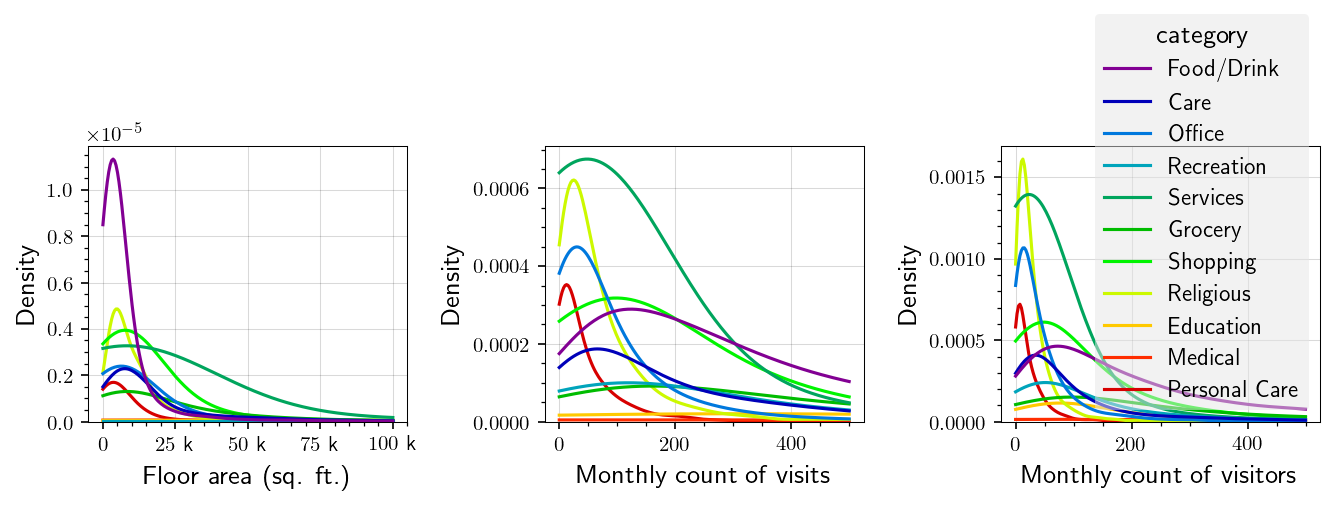

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for i, (var, label, vmax) in enumerate([
    ('area_sqft', 'Floor area (sq. ft.)', 1e5),
    ('visits', 'Monthly count of visits', 5e2),
    ('visitors', 'Monthly count of visitors', 5e2)
]):
    ax = U.plot(axes[i], xlab=label, xeng=var == 'area_sqft')
    ax = sns.kdeplot(poi, ax=ax, x=var, hue='category', 
                     clip=(0, vmax), palette='nipy_spectral')
    if i != 2: ax.get_legend().remove()
plt.tight_layout()

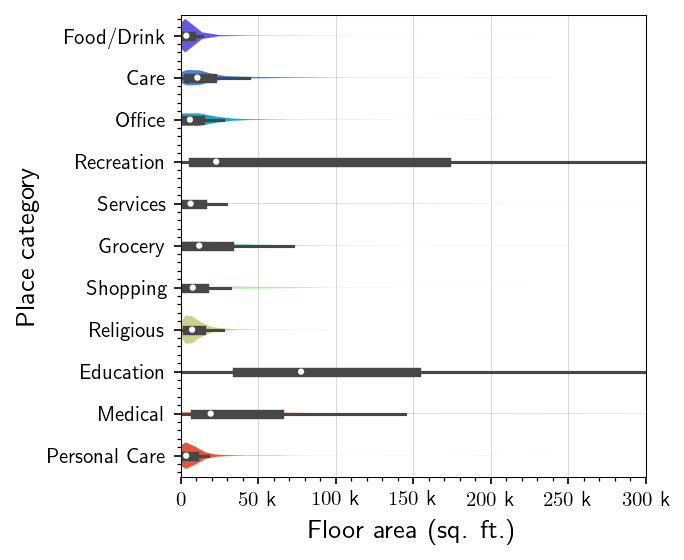

In [11]:
ax = U.plot(size=(4, 4), xlim=(0, 3e5), xeng=1)
sns.violinplot(poi, ax=ax, y='category', x='area_sqft', palette='rainbow')
for x in ax.collections: x.set_edgecolor('none')
U.plot(ax, xlab='Floor area (sq. ft.)', ylab='Place category');

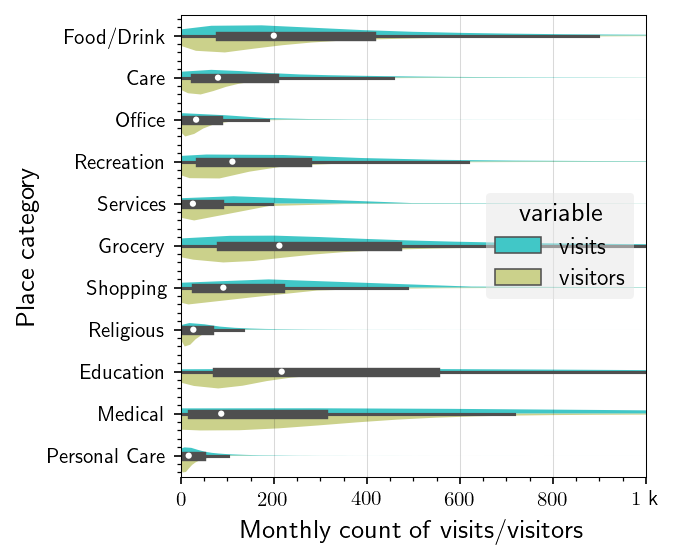

In [12]:
ax = U.plot(size=(4, 4), xlim=(0, 1e3), xeng=1)
sns.violinplot(poi.melt('category', ['visits', 'visitors']),
               ax=ax, y='category', x='value', hue='variable',
               split=True, palette='rainbow')
for x in ax.collections: x.set_edgecolor('none')
U.plot(ax, xlab='Monthly count of visits/visitors', ylab='Place category');